# Inspection of WEAVE first-light supercubes

## 1. Initialisation

### Imports

In [1]:
%matplotlib ipympl
from matplotlib import pyplot as plt
from matplotlib import colors
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy import constants as c

### Template sky spectrum

built with ESO SkyCalc: <http://www.eso.org/observing/etc/bin/gen/form?INS.MODE=swspectr+INS.NAME=SKYCALC>

In [2]:
wavelength_SkyCalc, intensity_SkyCalc = np.loadtxt("ESO-SkyCalc_radiance.txt", unpack=True)

wavelength_SkyCalc *= 10  # nm -> Angstrom
intensity_SkyCalc *= 1e-8*(c.h*c.c/u.Angstrom).to_value(u.erg)/wavelength_SkyCalc  # ph/s/m^2/arcsec^2/micron -> erg/s/cm^2/arcsec^2/Angstrom

## 2. Read data

### Datacubes:

In [3]:
class Datacube(object):
    def __init__(self, filename):
        self.hdu = fits.open(filename)
        
        self.wcs = WCS(self.hdu[1].header)
        self.wavelength = self.wcs.spectral.pixel_to_world(np.arange(self.hdu[1].data.shape[0])).to_value(u.Angstrom)
        #self.ngc7328a_x, self.ngc7328a_y = self.wcs.celestial.world_to_pixel(SkyCoord('22h35m56.7s', '+33d57m56s'))
        #self.ngc7328b_x, self.ngc7328b_y = self.wcs.celestial.world_to_pixel(SkyCoord('22h35m58.4s', '+33d57m57s'))
        self.Ha_x, self.Ha_y = self.wcs.celestial.world_to_pixel(SkyCoord('22h35m58.4s', '+33d57m57s'))

        self.sensitivity = self.hdu[5].data
        #self.ngc7328a = np.mean(self.hdu[1].data[:, int(self.ngc7328a_y-15):int(self.ngc7328a_y+15), int(self.ngc7328a_x-15):int(self.ngc7328a_x+15)], axis=(1, 2)) * self.sensitivity
        #self.ngc7328b = np.mean(self.hdu[1].data[:, int(self.ngc7328b_y-15):int(self.ngc7328b_y+15), int(self.ngc7328b_x-15):int(self.ngc7328b_x+15)], axis=(1, 2)) * self.sensitivity
        #self.sky = np.sum(self.hdu[3].data - self.hdu[1].data, axis=(1, 2)) * self.sensitivity / np.count_nonzero(self.hdu[6].data > 0)


In [4]:
LR_red = Datacube('data/supercube_2963102-001.fit')
LR_blue = Datacube('data/supercube_2963103-002.fit')
HR_red = Datacube('data/supercube_2963269.fit')
HR_blue = Datacube('data/supercube_2963270.fit')

## 3. Spectrophotometric calibration:
### Compute correction:

In [5]:

def find_continuum(x, y, n=1):
    peaks = np.where(y > 0); xx, yy = x[peaks], y[peaks]
    peaks = np.where((yy[1:-1] <= yy[:-2]) & (yy[1:-1] <= yy[2:])); xx, yy = xx[1:-1][peaks], yy[1:-1][peaks]
    xx = xx[1:-1]; yy = np.median(np.vstack((yy[:-2], yy[1:-1], yy[2:])), axis=0)
    while n > 1:
        peaks = np.where((yy[1:-1] <= yy[:-2]) & (yy[1:-1] <= yy[2:])); xx, yy = xx[1:-1][peaks], yy[1:-1][peaks]
        xx = xx[1:-1]; yy = np.median(np.vstack((yy[:-2], yy[1:-1], yy[2:])), axis=0)
        n -=1
    return xx, yy

wavelength_SkyCalc_continuum, intensity_SkyCalc_continuum = find_continuum(wavelength_SkyCalc, intensity_SkyCalc, 2);

for cube in [LR_red, LR_blue, HR_red, HR_blue]:
    wavelength, intensity = find_continuum(cube.wavelength, cube.sky, 3)
    correction =  np.interp(wavelength, wavelength_SkyCalc_continuum, intensity_SkyCalc_continuum) / intensity
    correction = np.interp(cube.wavelength, wavelength, correction)
    cube.correction = correction / np.median(correction)


In [7]:
lines = {}
lines['OII_3726'] = [3726.032, 3717.0, 3737.0]
lines['OII_3729'] = [3728.815, 3717.0, 3737.0]
lines['NeIII_3869'] = [3869.060, 3859.0, 3879.0]
lines['H_delta'] = [4101.734, 4092.0, 4111.0]
lines['H_gamma'] = [4340.464, 4330.0, 4350.0]
lines['OIII_4363'] = [4363.210, 4350.0, 4378.0]
lines['H_beta'] = [4861.325, 4851.0, 4871.0]
lines['OIII_4959'] = [4958.911, 4949.0, 4969.0]
lines['OIII_5007'] = [5006.843, 4997.0, 5017.0]
lines['HeI_5876'] = [5875.67, 5866.0, 5886.0]
lines['OI_6300'] = [6300.304, 6290.0, 6310.0]
lines['NII_6548'] = [6548.040, 6533.0, 6553.0]
lines['H_alpha'] = [6562.800, 6550., 6575., 6470., 6530., 6600., 6660.]
lines['NII_6584'] = [6583.460, 6573.0, 6593.0]
lines['SII_6717'] = [6716.440, 6704.0, 6724.0]
lines['SII_6731'] = [6730.810, 6724.0, 6744.0]
lines['CaT-a'] = [8500.36, np.nan, np.nan]
lines['CaT-b'] = [8544.44, np.nan, np.nan]
lines['CaT-c'] = [8664.52, np.nan, np.nan]

# NGC 7318
redshift_a = 6630/3e5
redshift_b = 5774/3e5

#wavelength_bins = np.array(lines['H_alpha'])
#indices_Ha_a = np.searchsorted(wavelength, wavelength_bins*(1+redshift_a))
#indices_Ha_b = np.searchsorted(wavelength, wavelength_bins*(1+redshift_b))


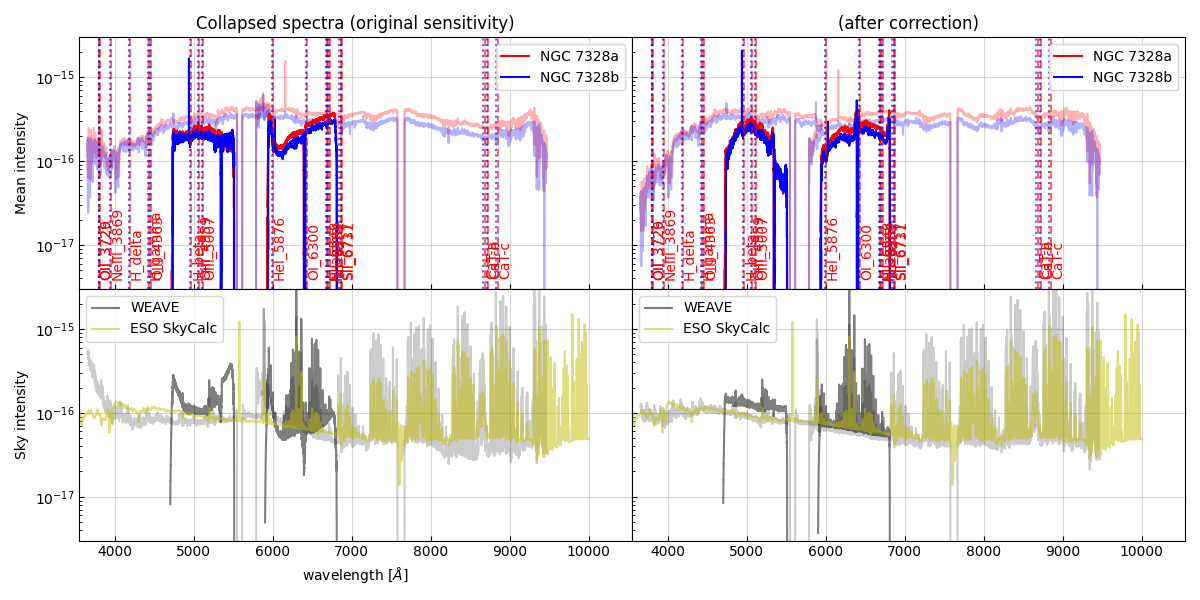

In [8]:
plt.close('spectra')
fig = plt.figure('spectra', figsize=(12, 6))
ax = fig.subplots(nrows=2, ncols=2, squeeze=False,
                  sharex=True, sharey=True,
                  gridspec_kw={'hspace': 0, 'wspace': 0}
                 )
for axis in ax.flatten():
    axis.tick_params(which='both', direction='in')
    axis.grid(alpha=.5)
fig.set_tight_layout(True)

ax[-1, 0].set_xlabel(r'wavelength [$\AA$]')
ax[-1, -1].set_xlim(3550, 10550)


ax[0, 0].set_title(r'Collapsed spectra (original sensitivity)')
ax[0, 0].set_ylabel(r'Mean intensity')

ax[0, 0].plot(LR_red.wavelength, LR_red.ngc7328a, 'r-', alpha=.3)
ax[0, 0].plot(LR_blue.wavelength, LR_blue.ngc7328a, 'r-', alpha=.3)
ax[0, 0].plot(LR_red.wavelength, LR_red.ngc7328b, 'b-', alpha=.3)
ax[0, 0].plot(LR_blue.wavelength, LR_blue.ngc7328b, 'b-', alpha=.3)

ax[0, 0].plot(HR_red.wavelength, HR_red.ngc7328a, 'r-', label='NGC 7328a')
ax[0, 0].plot(HR_blue.wavelength, HR_blue.ngc7328a, 'r-')
ax[0, 0].plot(HR_red.wavelength, HR_red.ngc7328b, 'b-', label='NGC 7328b')
ax[0, 0].plot(HR_blue.wavelength, HR_blue.ngc7328b, 'b-')

for line in lines:
    ax[0, 0].axvline(lines[line][0]*(1+redshift_a), c='r', alpha=.6, ls='--')
    ax[0, 0].axvline(lines[line][0]*(1+redshift_b), c='b', alpha=.6, ls=':')
    xmin, xmax = ax[0, 0].get_xlim()
    ymin, ymax = ax[0, 0].get_ylim()
    x0 = lines[line][0]*(1+redshift_a)
    if x0 > xmin and x0 < xmax:
        ax[0, 0].annotate(line, xy=(x0, .05), xycoords=('data', 'axes fraction'), rotation=90, color='r')
    #print(lines[line][0]*(1+redshift_a), ymin, line)

ax[0, 1].set_title(r'(after correction)')

ax[0, 1].plot(LR_red.wavelength, LR_red.ngc7328a*LR_red.correction, 'r-', alpha=.3)
ax[0, 1].plot(LR_blue.wavelength, LR_blue.ngc7328a*LR_blue.correction, 'r-', alpha=.3)
ax[0, 1].plot(LR_red.wavelength, LR_red.ngc7328b*LR_red.correction, 'b-', alpha=.3)
ax[0, 1].plot(LR_blue.wavelength, LR_blue.ngc7328b*LR_blue.correction, 'b-', alpha=.3)

ax[0, 1].plot(HR_red.wavelength, HR_red.ngc7328a*HR_red.correction, 'r-', label='NGC 7328a')
ax[0, 1].plot(HR_blue.wavelength, HR_blue.ngc7328a*HR_blue.correction, 'r-')
ax[0, 1].plot(HR_red.wavelength, HR_red.ngc7328b*HR_red.correction, 'b-', label='NGC 7328b')
ax[0, 1].plot(HR_blue.wavelength, HR_blue.ngc7328b*HR_blue.correction, 'b-')

for line in lines:
    ax[0, 1].axvline(lines[line][0]*(1+redshift_a), c='r', alpha=.6, ls='--')
    ax[0, 1].axvline(lines[line][0]*(1+redshift_b), c='b', alpha=.6, ls=':')
    xmin, xmax = ax[0, 0].get_xlim()
    ymin, ymax = ax[0, 0].get_ylim()
    x0 = lines[line][0]*(1+redshift_a)
    if x0 > xmin and x0 < xmax:
        ax[0, 1].annotate(line, xy=(x0, .05), xycoords=('data', 'axes fraction'), rotation=90, color='r')
    #print(line, lines[line][0]*(1+redshift_a), ymin)

ax[0, 0].legend()
ax[0, 1].legend()
ax[0, -1].set_yscale('log')
ax[0, -1].set_ylim(3e-18, 3e-15)


ax[1, 0].set_ylabel(r'Sky intensity')

ax[1, 0].plot(LR_red.wavelength, LR_red.sky, 'k-', alpha=.2)
ax[1, 0].plot(LR_blue.wavelength, LR_blue.sky, 'k-', alpha=.2)
ax[1, 0].plot(HR_red.wavelength, HR_red.sky, 'k-', alpha=.5)
ax[1, 0].plot(HR_blue.wavelength, HR_blue.sky, 'k-', alpha=.5, label='WEAVE')
ax[1, 0].plot(wavelength_SkyCalc, 4.5*intensity_SkyCalc, 'y-', alpha=.5, label='ESO SkyCalc')

ax[1, 0].legend()
ax[1, -1].set_yscale('log')
ax[1, -1].set_ylim(3e-18, 3e-15)

ax[1, 1].plot(LR_red.wavelength, LR_red.sky*LR_red.correction, 'k-', alpha=.2)
ax[1, 1].plot(LR_blue.wavelength, LR_blue.sky*LR_blue.correction, 'k-', alpha=.2)
ax[1, 1].plot(HR_red.wavelength, HR_red.sky*HR_red.correction, 'k-', alpha=.5)
ax[1, 1].plot(HR_blue.wavelength, HR_blue.sky*HR_blue.correction, 'k-', alpha=.5, label='WEAVE')
ax[1, 1].plot(wavelength_SkyCalc, 4.5*intensity_SkyCalc, 'y-', alpha=.5, label='ESO SkyCalc')

ax[1, 1].legend()

plt.show()